In [42]:
import os
import re
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    Flatten,
    Conv2D,
    MaxPooling2D,
)
from sklearn.metrics import classification_report
import keras
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [43]:
dirname = os.path.join(os.getcwd(), "data", "images")
filenames = os.listdir(dirname)
print(filenames)

images = []
directories = []
dircount = []
prevRoot = ""
cant = 0

print("leyendo imagenes de ", dirname)

for root, dirnames, filenames in os.walk(dirname):
    for filename in filenames:
        if re.search(r"\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant = cant + 1
            filepath = os.path.join(root, filename)
            image = plt.imread(filepath)
            images.append(image)
            b = "Leyendo..." + str(cant)
            if prevRoot != root:
                prevRoot = root
                directories.append(root)
                dircount.append(cant)
                cant = 0
dircount.append(cant)

dircount = dircount[1:]
dircount[0] = dircount[0] + 1
print("Directorios leidos:", len(directories))
print("Imagenes en cada directorio", dircount)
print("suma Total de imagenes en subdirs:", sum(dircount))

['combi', 'hummer', 'mini', 'porsche', 'vocho']
leyendo imagenes de  c:\Users\David\ia\cnn\data\images
Directorios leidos: 5
Imagenes en cada directorio [3615, 2320, 3710, 3970, 3745]
suma Total de imagenes en subdirs: 17360


In [44]:
labels = []
indice = 0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice = indice + 1
print("Cantidad etiquetas creadas: ", len(labels))

Cantidad etiquetas creadas:  17360


In [45]:
sriesgos = []
indice = 0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice, name[len(name) - 1])
    sriesgos.append(name[len(name) - 1])
    indice = indice + 1

0 combi
1 hummer
2 mini
3 porsche
4 vocho


In [46]:
y = np.array(labels)
X = np.array(images, dtype=np.uint8)  # convierto de lista a numpy

classes = np.unique(y)
nClasses = len(classes)
print("Total number of outputs : ", nClasses)
print("Output classes : ", classes)

Total number of outputs :  5
Output classes :  [0 1 2 3 4]


In [47]:
train_X, test_X, train_Y, test_Y = train_test_split(X, y, test_size=0.2)
print("Training data shape : ", train_X.shape, train_Y.shape)
print("Testing data shape : ", test_X.shape, test_Y.shape)

Training data shape :  (13888, 80, 80) (13888,)
Testing data shape :  (3472, 80, 80) (3472,)


Text(0.5, 1.0, 'Ground Truth : 4')

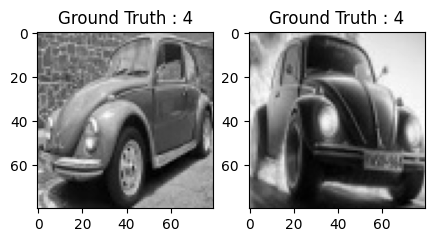

In [48]:
plt.figure(figsize=[5, 5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_X[0, :, :], cmap="gray")
plt.title("Ground Truth : {}".format(train_Y[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_X[0, :, :], cmap="gray")
plt.title("Ground Truth : {}".format(test_Y[0]))

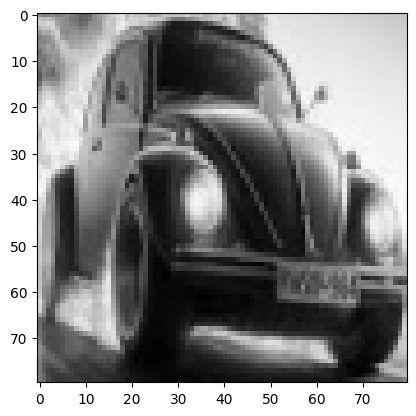

In [49]:
train_X = train_X.astype("float32")
test_X = test_X.astype("float32")
train_X = train_X / 255.0
test_X = test_X / 255.0
plt.imshow(test_X[0, :, :], cmap="gray")

In [50]:
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)
print("Original label:", train_Y[0])
print("After conversion to one-hot:", train_Y_one_hot[0])

Original label: 4
After conversion to one-hot: [0. 0. 0. 0. 1.]


In [51]:
print(f"train_X shape: {train_X.shape}")
print(f"train_Y_one_hot shape: {train_Y_one_hot.shape}")
# Mezclar todo y crear los grupos de entrenamiento y testing
train_X, valid_X, train_label, valid_label = train_test_split(
    train_X, train_Y_one_hot, test_size=0.2, random_state=13
)
print(train_X.shape, valid_X.shape, train_label.shape, valid_label.shape)

train_X shape: (13888, 80, 80)
train_Y_one_hot shape: (13888, 5)
(11110, 80, 80) (2778, 80, 80) (11110, 5) (2778, 5)


In [52]:
# declaramos variables con los parámetros de configuración de la red
INIT_LR = 1e-3  # Valor inicial de learning rate. El valor 1e-3 corresponde con 0.001
epochs = (
    100  # Cantidad de iteraciones completas al conjunto de imagenes de entrenamiento
)
batch_size = 32  # cantidad de imágenes que se toman a la vez en memoria

In [53]:
car_model = Sequential(
    [
        Conv2D(
            32,
            (3, 3),
            activation="relu",
            input_shape=(80, 80, 1),
        ),
        MaxPooling2D((2, 2)),
        Conv2D(
            64,
            (3, 3),
            activation="relu",
        ),
        MaxPooling2D((2, 2)),
        Conv2D(
            128,
            (3, 3),
            activation="relu",
        ),
        MaxPooling2D((2, 2)),
        Conv2D(
            256,
            (3, 3),
            activation="relu",
        ),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        Flatten(),
        Dense(256, activation="relu"),
        Dense(128, activation="relu"),
        Dense(nClasses, activation="softmax"),
    ]
)

c:\Users\David\ia\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [54]:
car_model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"],
)

In [55]:
data_gen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=15,
    zoom_range=[0.7, 1.4],
)
train_X = train_X.reshape(train_X.shape[0], 80, 80, 1)

data_gen_train = data_gen.flow(
    train_X, train_label, batch_size=batch_size, shuffle=False
)

In [56]:
car_train = car_model.fit(
    train_X,
    train_label,
    # data_gen_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data=(valid_X, valid_label),
)

Epoch 1/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.3597 - loss: 1.4313 - val_accuracy: 0.6350 - val_loss: 0.9206
Epoch 2/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.6816 - loss: 0.8457 - val_accuracy: 0.7451 - val_loss: 0.7094
Epoch 3/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.7799 - loss: 0.6235 - val_accuracy: 0.7970 - val_loss: 0.5750
Epoch 4/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.8114 - loss: 0.5148 - val_accuracy: 0.8132 - val_loss: 0.5241
Epoch 5/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.8400 - loss: 0.4491 - val_accuracy: 0.8229 - val_loss: 0.4893
Epoch 6/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.8665 - loss: 0.3722 - val_accuracy: 0.8344 - val_loss: 0.4930
Epoch 7/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.8886 - loss: 0.3151 - val_accuracy: 0.8459 - val_loss: 0.4780
Epoch 8/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.9036 - loss: 0.2696 - 

In [57]:
car_model.save(os.path.join(os.getcwd(), "model.h5"))

In [58]:
test_eval = car_model.evaluate(test_X, test_Y_one_hot, verbose=1)

109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8555 - loss: 0.4932


In [59]:
predicted_classes2 = car_model.predict(test_X)

109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


In [60]:
predicted_classes = []
for predicted_car in predicted_classes2:
    predicted_classes.append(predicted_car.tolist().index(max(predicted_car)))
predicted_classes = np.array(predicted_classes)

In [61]:
target_names = ["Class {}".format(i) for i in range(nClasses)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.88      0.89      0.89       710
     Class 1       0.91      0.85      0.88       472
     Class 2       0.90      0.84      0.87       735
     Class 3       0.88      0.88      0.88       816
     Class 4       0.76      0.82      0.79       739

    accuracy                           0.86      3472
   macro avg       0.86      0.86      0.86      3472
weighted avg       0.86      0.86      0.86      3472

